# AutoML Competitions: a Meta-Learning Perspective

**Anonymous authors**

This notebook contains all experiments and plots presented in the paper "AutoML Competitions: a Meta-Learning Perspective" submitted to [AutoML-Conf 2022](https://automl.cc/).

Automated Machine Learning (AutoML) competitions seek to uncover best solutions to multiple tasks, which might generalize to similar tasks, without human intervention: a meta-learning problem. By casting the problem of judging such competitions as a meta-learning problem, this paper provide a theoretical analysis, which outlines the danger of over-fitting the tasks of a competition. Such (meta-)over-fitting worsens as the number 𝑛 of competition participants increases. We propose a simple scheme to choose the winner, which alleviates this problem, in two-phase competitions having an identical number of similar tasks: the top-k algorithm.

In this notebook, we evaluate the top-k algorithm in various settings: on artificial data and on real data.

**Notebook outline:**

**1. [Artificial / theoretical case](#part1)**

**2. [One task case](#part2)**

**3. [Multi-task (AutoML) case](#part3)**

In [55]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import comb, factorial # combination (binomial coefficient) and factorial function
from numpy.linalg.linalg import matrix_power # matrix power (Chapman-Kolmogorov equation)
import sys
sys.path.append('../ranky')
import ranky as rk # select_k_best is implemented in Ranky (https://github.com/didayolo/ranky)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='part1'></a>
# 1. Artificial / theoretical case

Two rankings D and F (representing developmment and final leaderboards) are generated by applying $s$ random swaps on a ground truth ranking $g = [1, 2, ..., n]$.

### acc(k=1) = acc(k=n) = ?

Empirical estimation of $acc(k=n)$, the probability that the winner stays in the first position after the $s$ random swaps, as a function of $\phi = \frac{s}{n}$.

### Markov chain approach
We model the movements of a candidate during the swaps using a Markov chain and a binomial distribution.

We fix the probability of the binomial distribution to $p= \frac{2}{n-1}$

In the Markov chain, we have a "hard wall" below 0 so the "walker" will either stay at 0 or move up to 1
(+ another wall above n)

We obtain the probability of going from the position a to the position b by modelling our problem using the Chapman-Kolmogorov equation.

![Markov chain scheme](images/markov_chain.png)

In [56]:
def bernouilli(N, S, p=0.5):
    ''' Probability of having exactly S successes from N Bernouilli trials with probability p.
        (loi binomiale)
    '''
    return comb(N, S) * (p ** S) * ((1-p) ** (N-S))

def transition_matrix(n):
    ''' The transition matrix leads, from any state, to a better position or a worst position with a probability of 0.5.
        EXCEPT for the first (0) and last (n) position, where there is a probability of 0.5 of staying in place.
    
                            [[0.5, 0.5, 0  ],     
    transition_matrix(3) =  [0.5, 0  , 0.5],
                            [0  , 0.5, 0.5]]
    '''
    T = []
    first = [0 for _ in range(n)]
    first[0] = 0.5
    first[1] = 0.5
    T.append(first)
    for i in range(n-2):
        row = [0 for _ in range(n)]
        row[i] = 0.5
        row[i+2] = 0.5
        T.append(row)
    last = [0 for _ in range(n)]
    last[n-2] = 0.5
    last[n-1] = 0.5
    T.append(last)    
    return np.array(T)

def proba_move(a, b, n, N):
    ''' Probability of ending up in position b from the starting position a after N moves, in a list of n elements.
    '''
    T = transition_matrix(n)
    TN = matrix_power(T, N)
    return TN[a][b]

def approx_walk(a, b, n, N):
    ''' Probability of ending up at position b from position a after N neighbor swaps of the list of size n.
    '''
    p = 2 / (n-1) # probability of being selected
    res = 0
    for S in range(N+1):
        # bernouilli: proba that the number of steps S mentionned occurs
        # proba_move: proba of returning to the origin after S steps
        res += bernouilli(N, S, p=p) * proba_move(a, b, n, S)
    return res

def proba_top_k(a, k, n, N):
    ''' Probability of ending up in positions [0, k] from the starting position a after N moves, in a list of n elements.
    '''
    return np.sum([approx_walk(a, b, n, N) for b in range(k)])

Let's compare the empirical probability that the true winner wins to the predicted $acc(k=1)$

In [57]:
# Data points
_phi = []
_pk = []
_approx = []
_approx_walk = []

# Parameters
trials = 10000
_n = [20]
_N = list(range(20*5))

for n in tqdm(_n):
    for N in _N:
        # Artificial judges
        g = rk.generator.SwapGenerator()
        g.fit(list(range(n)))
        # Compute the rank of the true winner
        d = pd.DataFrame(g.sample(N=N, n=trials))
        winner_ranks = d.loc(0)[0]
        pk = winner_ranks.isin([0]).sum(axis=0) / trials
        # Store values
        _phi.append(N/n)
        _pk.append(pk)
        #_approx.append(approx(n, N))
        _approx_walk.append(approx_walk(0, 0, n, N))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:15<00:00, 195.38s/it]


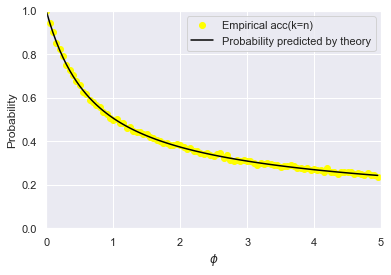

In [60]:
# PLOT
plt.plot(_phi, _pk, 'o', label='Empirical acc(k=n)', color='yellow')
plt.plot(_phi, _approx_walk, '-', label='Probability predicted by theory', color='black')
plt.xlim((0, 5))
plt.ylim((0, 1))
plt.xlabel('$\phi$')
plt.ylabel('Probability')
plt.legend()
plt.show()

# k* 

Empirical estimation of $k* = argmax ~ acc(k)$ as a function of $\phi$. 

$k*$ is the optimal argument of select-k-best such that the probability of selecting the winner is maximized.

We need to estimate:
- The probability of being in the top k (distance from origin < k after N steps)
- For each candidate, the probability of being in top k and the probability of being ranked first

acc(k) = P(true winner ranked first | true winner in top k) * P(true winner in top k)

Let's see the first part P(tw ranked first | tw in top k)
- For each candidates we compute P(in top k) * P(ranked first)
- For the true winner we have P(tw in top k) = approx_set_walk and P(tw ranked first) = acc(k=1)

_If we make the (false) hypothesis that the events are indenpendents..._

In [64]:
def approx_pk(n, N, k):
    ''' Approximation of acc(k), the probability that the true winner is selected by select-k-best method.
    '''
    prior = proba_top_k(0, k, n, N) # P(true winner in top k)
    pk = proba_move(0, 0, n, N) # # P(k=1) = P(k=n) = proba of winner wining
    for e in range(1, n): # all other candidates
        # P(K) is increased when another candidate would win but is not in topk
        pk += (1 - proba_top_k(e, k, n, N)) * proba_move(e, 0, n, N)   
    return pk * prior

def approx_k_star(n, N):
    return np.argmax([approx_pk(n, N, k) for k in range(n)])

def select_winner(topk, F):
    """ Return the first element from topk in F.
    """
    for e in F:
        if e in topk:
            return e

def evaluate_acc_artificial(n, N, trials=200, return_d=False):
    """ Estimate empirically the accuracy of top-k on artificial data.
    
    If return_d, estimate empirically the average of kendall tau distance between D and F, on artificial data.
    """
    accs = np.zeros(n)
    d = 0
    g = rk.generator.SwapGenerator() # Artificial judges
    g.fit(list(range(n)))
    for _ in range(trials):
        D = g.sample(N=N, n=1)
        F = g.sample(N=N, n=1)
        for k in range(1, n+1):
            winner = select_winner(D[:k], F) # top-k
            if winner == 0: # The selection went well
                accs[k-1] += 1 # count when the true winner wins
        if return_d: # estimation of Kendall tau distance
            d += rk.kendall_tau_distance(D, F, normalize=True)
    if return_d:
        return (accs / trials), (d / trials)
    return (accs / trials)

def evaluate_k_star(n, N, trials=200, return_d=False):
    """ Estimate k* (optimal value of k) empirically on artificial data.
    """
    _k = range(1, n+1)
    if return_d:
        accs, d = evaluate_acc_artificial(n, N, trials=trials, return_d=True)
        return _k[np.argmax(accs)], d
    else:
        accs = evaluate_acc_artificial(n, N, trials=trials)
        return _k[np.argmax(accs)]

def evaluate_d(n, N, trials=200):
    """ OBSOLOTE
    
    Estimate empirically the average of kendall tau distance between D and F, on artificial data.
    """
    g = rk.generator.SwapGenerator()
    g.fit(list(range(n)))
    _d = []
    for _ in range(trials):
        # Artificial judges
        # Compute the rank of the true winner
        D = g.sample(N=N, n=1)
        F = g.sample(N=N, n=1)
        _d.append(rk.kendall_tau_distance(D, F, normalize=True))
    return np.mean(_d)

#### What is the behavior of $k*$ when $\phi$ varies?

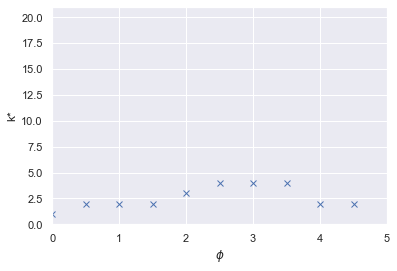

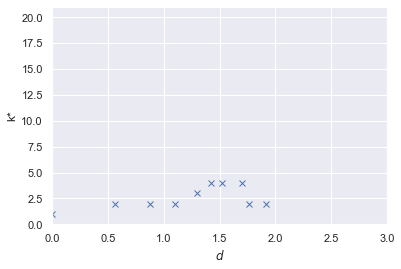

In [65]:
# k*
# Compare k* to phi (and to Kendall distance between D and F)
_phi, _d, _k_star = [], [], []
for n in [20]:
    for N in range(0, 100, 10):
        k_star, d = evaluate_k_star(n, N, trials=100, return_d=True)
        _phi.append(N / n)
        _d.append(d)
        _k_star.append(k_star)

# Plot
plt.plot(_phi, _k_star, 'x')
plt.xlabel('$\phi$')
plt.ylabel('k*')
plt.xlim((0, 5))
plt.ylim((0, n+1))
plt.show()

# Plot
plt.plot(_d, _k_star, 'x')
plt.xlabel('$d$')
plt.ylabel('$k*$')
plt.xlim((0, 3))
plt.ylim((0, n+1))
plt.show()

#### Empirical evaluation of $acc(k)$

-  Evaluate acc(k)
-  TODO: Meta-training / meta-generalization curves for values of k (as for real data)
-  What is meta-train in this case? 

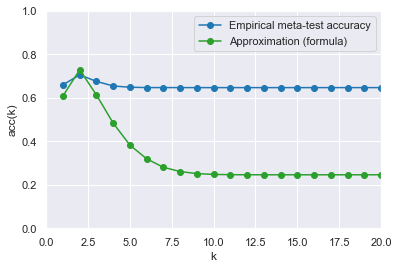

In [66]:
n, N = 20, 10
_k = range(1, n+1)
y = evaluate_acc_artificial(n, N, trials=5000)
y2 = [approx_pk(n, N, k) for k in _k]

# Plot
plt.plot(_k, y, 'o-', label='Empirical meta-test accuracy', color='tab:blue')
plt.plot(_k, y2, 'o-', label='Approximation (formula)', color='tab:green')
plt.xlim((0, 20))
plt.ylim((0, 1))
plt.xlabel('k')
plt.ylabel('acc(k)')
plt.legend()
plt.show()

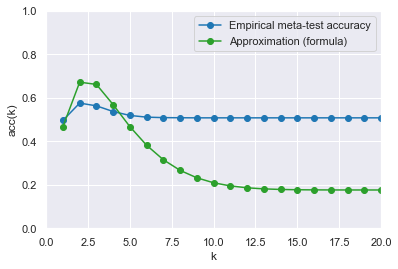

In [104]:
n, N = 20, 20
_k = range(1, n+1)
y = evaluate_acc_artificial(n, N, trials=5000)
y2 = [approx_pk(n, N, k) for k in _k]

# Plot
plt.plot(_k, y, 'o-', label='Empirical meta-test accuracy', color='tab:blue')
plt.plot(_k, y2, 'o-', label='Approximation (formula)', color='tab:green')
plt.xlim((0, 20))
plt.ylim((0, 1))
plt.xlabel('k')
plt.ylabel('acc(k)')
plt.legend()
plt.show()

#### Empirical and predicted $k*$

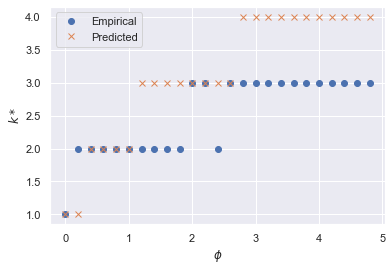

In [79]:
# k*
emp_ks, pre_ks, _phi = [], [], []
n = 10
_N = range(0, 50, 2)
for N in _N:
    emp_ks.append(evaluate_k_star(n, N, trials=5000))
    pre_ks.append(approx_k_star(n, N))
    _phi.append(N / n)

# Plot
plt.plot(_phi, emp_ks, 'o', label='Empirical')
plt.plot(_phi, pre_ks, 'x', label='Predicted')
plt.xlabel('$\phi$')
plt.ylabel('$k*$')
plt.legend()
plt.show()

#### $\phi$ vs $d$

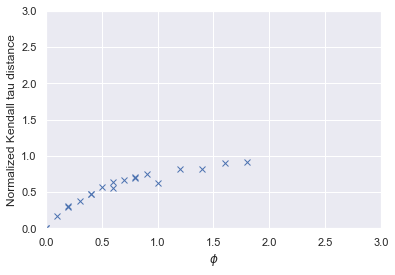

In [47]:
# Compare phi and Kendall distance
_phi, _d = [], []
for n in [5, 10]:
    for N in range(10):
        _phi.append(N / n)
        _d.append(evaluate_d(n, N, trials=100))

# Plot
plt.plot(_phi, _d, 'x')
plt.xlabel('$\phi$')
plt.ylabel('d')
plt.xlim((0, 3))
plt.ylim((0, 3))
plt.show()

#### Estimation of $\phi = \frac{s}{n}$ on artificial data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:13<00:00,  2.58it/s]


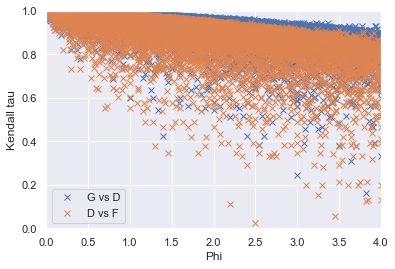

In [3]:
_phi = []
_corr = []
_corr_df = []
for n in tqdm(range(10, 200)):
    for N in range(0, 200):
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _phi.append(N/n)
        _corr.append(rk.corr(g.sample(), g.sample(N=N), method='kendalltau'))
        _corr_df.append(rk.corr(g.sample(N=N), g.sample(N=N), method='kendalltau'))

# PLOT
plt.plot(_phi, _corr, 'x', label='G vs D')
plt.plot(_phi, _corr_df, 'x', label='D vs F')
plt.xlim((0, 4))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Kendall tau')
plt.legend()
plt.show()

n = 50


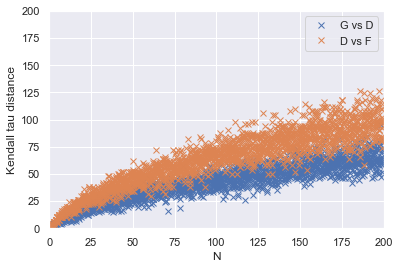

In [20]:
print('n = 50')
_phi = []
_corr = []
_corr_df = []
n = 50
_N = []
_log = []
for N in range(0, 200):
    for _ in range(10): # re-runs
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _N.append(N)
        _corr.append(rk.kendall_tau_distance(g.sample(), g.sample(N=N)))
        _corr_df.append(rk.kendall_tau_distance(g.sample(N=N), g.sample(N=N)))

# PLOT
plt.plot(_N, _corr, 'x', label='G vs D')
plt.plot(_N, _corr_df, 'x', label='D vs F')
plt.xlim((0, 200))
plt.ylim((0, 200))
plt.xlabel('N')
plt.ylabel('Kendall tau distance')
plt.legend()
plt.show()

<a id='part2'></a>
# 2. One task case

##### Evaluate select-K-best on various 1 task problems

TODO

- All datasets in one plot
- AutoDL benchmark data too (light version)
- Use the validation data instead of test for the development phase?
- Accuracy of selecting the post-challenge winner (instead of score, and compare both)

In [49]:
def evaluate_acc_real(M, trials=200, ranks=False, return_d=False):
    """ Evaluate accuracy and score of top-k method on real data.
    
    From a matrix of scores M (rows are candidates, columns are judges).
    Bootstrap (shuffle), then split in 3 and compute the acc/score.
    Same code for 2. and 3.
    
    If return_d, estimate the normalized tau distance between D and F and return it
    """
    M = np.array(M)
    n, m = M.shape # n candidates (rows), m judges (columns)
    accs = np.zeros(n)
    te_scores = np.zeros(n) # meta-test scores
    tr_scores = np.zeros(n) # meta-train scores
    d = 0 # kendall distance
    th = int(m/3)
    for _ in range(trials):
        _M = rk.bootstrap(M, axis=1) # shuffle judges
        D, F, P = _M[:,:th], _M[:,th:2*th], _M[:,2*th:] # dev, final, post
        if ranks: # this way the average score will be the aveage rank instead
            D, F, P = rk.rank(D), rk.rank(F), rk.rank(P)
        D, F, P = rk.score(D), rk.score(F), rk.score(P) # average
        if return_d:
            d += rk.kendall_tau_distance(D, F, normalize=True)
        for k in range(1, n+1):
            top_k = rk.select_k_best(D, k=k, reverse=True)
            winner = rk.select_best(F[top_k], reverse=True)
            winner_score = P[winner]
            tr_scores[k-1] += np.min(F[top_k]) # min or max TODO
            te_scores[k-1] += winner_score
            #accs[k-1] += (winner == P[0]) # +1 if top-k worked
    if return_d:
        return (tr_scores / trials), (te_scores / trials), (d / trials)
    return (tr_scores / trials), (te_scores / trials)

In [50]:
path = 'data/automl_predictions'
reference = 'reference'
candidates = ['aad_freiburg', 'gaussian_nb_default', 'abhishek', 'jameslloyd',
              'rf_autosklearn', 'asml_intel', 'knn_autosklearn', 'rf_default',
              'baseline', 'knn_default', 'sgd_autosklearn', 'lise_sun', 'sgd_default', 'djajetic', 'marc_boulle', 'gaussian_nb_autosklearn']
# 'bayesian_ridge_default'
datasets = ['fabert', 'adult', 'alexis', 'arturo', 'digits']
metric = 'accuracy'

In [51]:
def create_score_matrix(dataset, path, reference, candidates, metric):
    # Create matrix
    M = []
    ref_file = os.path.join(path, reference, dataset+'_test.solution')
    ref = pd.read_csv(ref_file, sep=" ", header=None)
    ref = ref.drop([ref.columns[-1]], axis=1) # fix problem in format
    # Development, Final and Post-challenge phases
    for candidate in candidates:
        files = glob(os.path.join(path, candidate, dataset+'_test*.predict'))
        pred_file = sorted(files)[-1] # last predictions
        pred = pd.read_csv(pred_file, sep=" ", header=None)
        pred = pred.drop([pred.columns[-1]], axis=1)  
        l = [rk.metric([ref.loc[i]], [pred.loc[i]], method=metric) for i in range(ref.shape[0])] # DIRTY
        M.append(l)
    M = pd.DataFrame(M)
    M.index = candidates
    return M

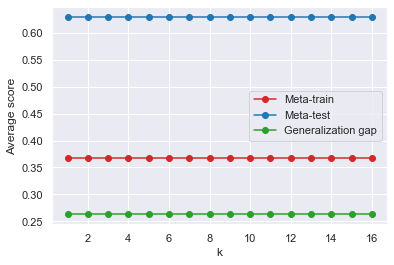

In [52]:
#for dataset in datasets:
dataset = datasets[1]
data = create_score_matrix(dataset, path, reference, candidates, metric)

# Top-k scores
_k = range(1, data.shape[0]+1)
tr, te, d = evaluate_acc_real(data, ranks=False, trials=1, return_d=True)

# Plot
plt.plot(_k, tr, 'o-', label='Meta-train', color='tab:red')
plt.plot(_k, te, 'o-', label='Meta-test', color='tab:blue')
plt.plot(_k, np.abs(tr - te), 'o-', label='Generalization gap', color='tab:green')
plt.xlabel('k')
plt.ylabel('Average score')
plt.legend(loc='center right')
plt.show()

In [26]:
d

1.6525

#### Estimation of $\phi = \frac{s}{n}$ on real data

Using Kendall distance?

<a id='part3'></a>
# 3. Multi-task (AutoML) case

TODO: 
- Include many benchmarks
- Compare with theoretical approximation
- Compute accuracy

In [34]:
benchmarks = ['AutoDL-AUC.data', 'AutoML.data', 'Statlog.data', 'OpenML.data']
path = 'data/benchmarks'

In [43]:
def automl_experiment(data, trials=200):
    # Top-k scores
    _k = range(1, data.shape[0]+1)
    tr, te, d = evaluate_acc_real(data, ranks=True, trials=trials, return_d=True)
    # Plot
    plt.plot(_k, tr, 'o-', label='Meta-train', color='tab:red')
    plt.plot(_k, te, 'o-', label='Meta-test', color='tab:blue')
    plt.plot(_k, np.abs(tr - te), 'o-', label='Generalization gap', color='tab:green')
    plt.xlabel('k')
    plt.ylabel('Average rank')
    plt.legend(loc='center right')
    plt.show()
    print('d = {}'.format(d))

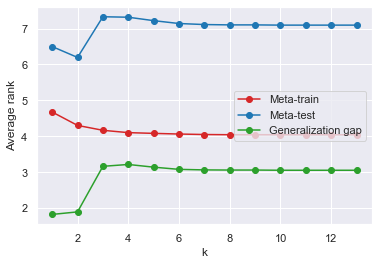

d = 2.5001538461538453


In [44]:
# AutoDL
data = pd.read_csv(os.path.join(path, benchmarks[0]), header=None, sep=' ').T
automl_experiment(data, trials=500)

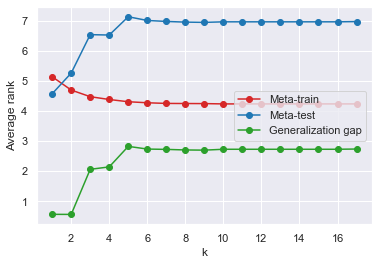

d = 2.9977647058823496


In [45]:
# AutoML
data = pd.read_csv(os.path.join(path, benchmarks[1]), header=None, sep=' ').T
automl_experiment(data, trials=500)

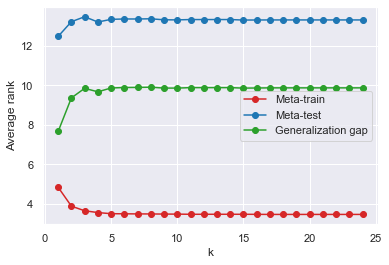

d = 5.6270000000000024


In [46]:
# Statlog
data = pd.read_csv(os.path.join(path, benchmarks[2]), header=None, sep=' ').T
automl_experiment(data, trials=500)

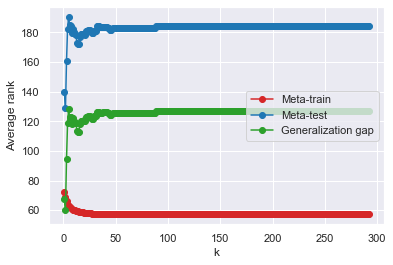

d = 69.23404109589042


In [47]:
# OpenML
data = pd.read_csv(os.path.join(path, benchmarks[3]), header=None, sep=' ').T
automl_experiment(data, trials=50)

#### Estimation of $\phi = \frac{s}{n}$ on real data

# ARCHIVE | OLD EXPERIMENTS

In [13]:
#############
#### OLD ####
#############

# Data points
_phi = [] # keep track of N/n ratio
_maxk = [] # keep track of k value
_maxpk = [] # estimated p(k)
_predicted_k_star = []
_approx_walk = [] # approximation of p(k) using random walks

# Parameters
trials = 200 #2500 #5000
_n = [20] #[5, 10, 15] #, 20, 25, 30]
_N = [10, 40, 180] #, 720] #[3, 6, 9, 12, 15] #[1, 2, 3, 4, 5] #, 6, 7, 8, 9, 10]

for n in _n: # number of candidates
    for N in tqdm(_N):   # number of swaps
        _acc = []
        _k = []
        for k in range(1, n): # for select-k-best # begining at 1, at 2 ??? wtf here?
            # Artificial judges
            g = rk.generator.SwapGenerator()
            g.fit(list(range(n)))
            count = 0 # count when the true winner wins
            for _ in range(trials):
                # Compute the rank of the true winner
                D = g.sample(N=N, n=1)
                F = g.sample(N=N, n=1)
                # Select k best
                winner = select_winner(D[:k], F)
                if winner == 0: # The selection went well
                    count += 1
            _acc.append(count / trials) # Estimated probability of selecting the true winner
            _k.append(k)
        _phi.append(N/n) # Noise factor
        k_star = _k[np.argmax(_acc)] # Empirical k*
        _maxk.append(k_star)
        _maxpk.append(np.max(_pk))
        predicted_k_star = approx_k_star(n, N)
        _predicted_k_star.append(predicted_k_star)
        _approx_walk.append(approx_pk(n, N, predicted_k_star))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:32<00:00, 113.01s/it]


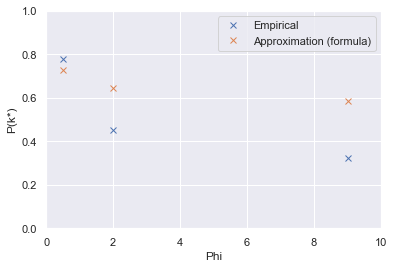

In [17]:
# acc(k*)
plt.plot(_phi, _maxpk, 'x', label='Empirical')
plt.plot(_phi, _approx_walk, 'x', label='Approximation (formula)')
plt.xlim((0, 10))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('P(k*)')
plt.legend()
plt.show()

acc(k\*) seems to be overestimated. Is empirical k\* and predicted k\* the same?

The difference may be explained by the fact that the predicted k\* is not the empirical k\* here... and we approximate acc(k\*) on the k\* given by the theory...

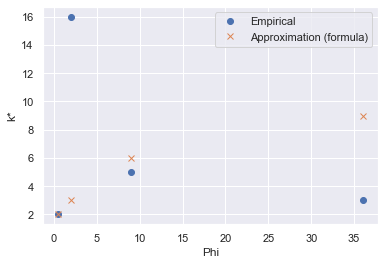

In [15]:
# K*
plt.plot(_phi, _maxk, 'o', label='Empirical')
plt.plot(_phi, _predicted_k_star, 'x', label="Approximation (formula)")
plt.xlabel('Phi')
plt.ylabel('k*')
plt.legend()
plt.show()

In [53]:
###############
##### OLD #####
###############
# In part 2
results = []
for dataset in tqdm(datasets):
    m1, m2, m3 = [], [], []
    ref_file = os.path.join(path, reference, dataset+'_test.solution')
    ref = pd.read_csv(ref_file, sep=" ", header=None)
    ref = ref.drop([ref.columns[-1]], axis=1) # fix problem in format
    # Development, Final and Post-challenge phases
    th = int(ref.shape[0]/3)
    ref1, ref2, ref3 = ref[:th], ref[th:2*th], ref[2*th:]
    for candidate in candidates:
        files = glob(os.path.join(path, candidate, dataset+'_test*.predict'))
        pred_file = sorted(files)[-1]
        pred = pd.read_csv(pred_file, sep=" ", header=None)
        pred = pred.drop([pred.columns[-1]], axis=1)
        pred1, pred2, pred3 = pred[:th], pred[th:2*th], pred[2*th:]
        
        s1, s2, s3 = rk.metric(ref1, pred1, method=metric), rk.metric(ref2, pred2, method=metric), rk.metric(ref3, pred3, method=metric)
        m1.append(s1)
        m2.append(s2)
        m3.append(s3)
    m1, m2, m3 = pd.Series(m1, index=candidates), pd.Series(m2, index=candidates), pd.Series(m3, index=candidates)
    results.append([m1, m2, m3])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


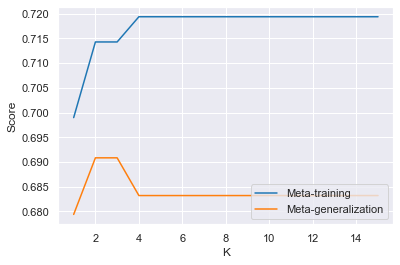

In [54]:
# On dataset Fabert
for result in results:
    mtr_scores = []
    mte_scores = []
    m1, m2, m3 = result
    x = range(1, len(m1))
    for k in x:
        mtr_scores.append(m2[rk.select_k_best(m1, k=k)].max())
        mte_scores.append(m3[rk.select_best(m2[rk.select_k_best(m1, k=k)])])
    plt.plot(x, mtr_scores, label='Meta-training', color='tab:blue')
    plt.plot(x, mte_scores, label='Meta-generalization', color='tab:orange')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()